## Initial Mind Map
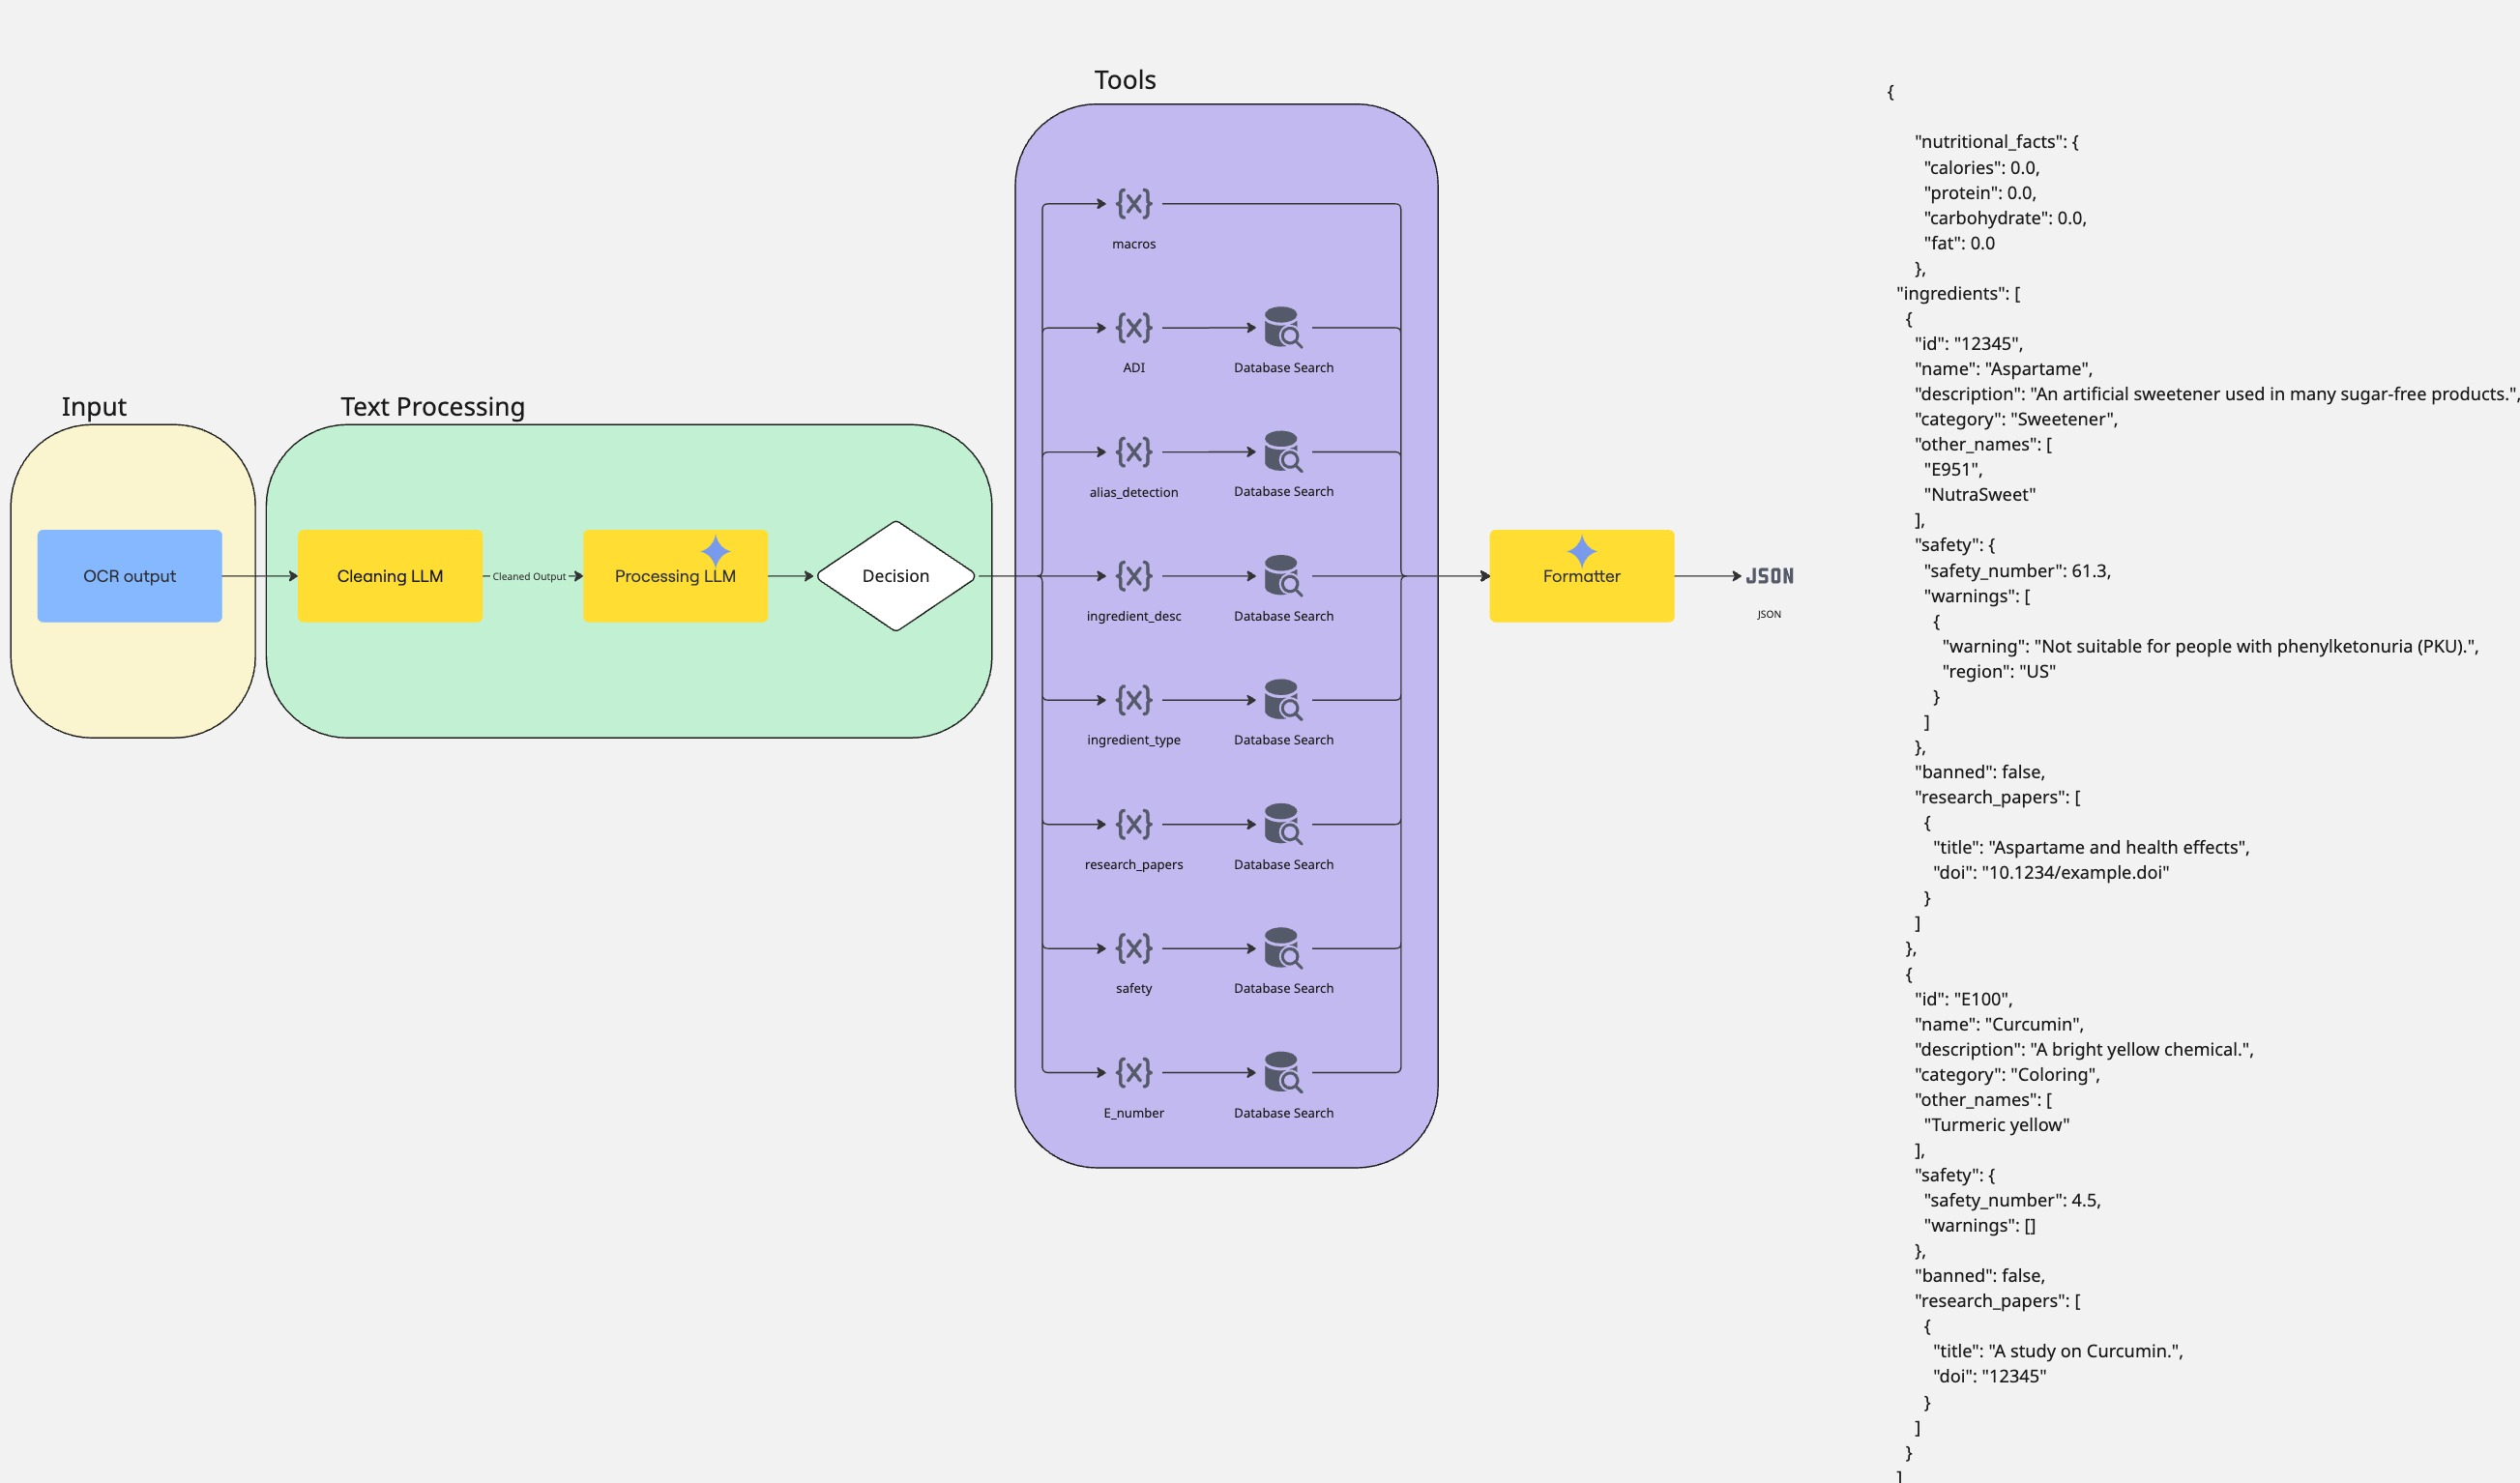

### To Do's:
- [x] Cleaning LLM
- [x] Processing LLM
- [x] Macros
- [x] Alias
- [x] Ingredient Description
- [x] Research Papers
- [ ] Safety
  - [ ] Warning/Allergens
- [x] E-Number
- [x] Ban Check
- [x] Ingredient Type (E.g. Sweetener, Perservative)


- [ ] **Formatter**


# Imports

In [1]:
from google import genai
from google.genai import types
import requests
import os
import google.generativeai as gemini
import json
import urllib.parse  
import re, requests, pandas as pd
from io import StringIO
import pandas as pd 
import app_config
import agent_tools
import app_prompts
import helper_funcs
import tool_schemas
from typing import Text
import textwrap
from dotenv import load_dotenv


/opt/homebrew/Caskroom/miniconda/base/envs/food311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup
* Get a Gemini API key at - https://aistudio.google.com/app/apikey
* Models - https://ai.google.dev/gemini-api/docs/models

In [2]:
load_dotenv()
GEMINI_API_KEY = os.getenv("GEMINI_KEY")


# GEMINI_API_KEY = api_key.GEMINI_KEY
models = app_config.models

relevant_keywords = agent_tools.relevant_keywords

aliases_schema = tool_schemas.aliases_schema
e_number_schema = tool_schemas.e_number_schema
research_papers_schema = tool_schemas.research_papers_schema
warnings_schema = tool_schemas.warnings_schema

formatter_schema = app_config.FORMATTER_SCHEMA

warnings_path = app_config.warnings_path
e_numbers_path = app_config.e_numbers_path
warning_df = pd.read_csv(warnings_path).set_index("ingredient")
warning_df.index = warning_df.index.astype(str).str.strip().str.lower()

# Cleaning OCR Text

### OCR Output

In [3]:
OCR_file = "ocr_text.txt"

OCR_text = """
NNUTRITION FACTS
Serving Size: 30g
Servings Per Container: about 10
Calories 150
Total Fat 8g
Saturated Fat 3g
Trans Fat 6g
Cholesterol 16mg
Sodium 120mg
Total Carbohydrate 18g
Dietary Fiber 2g
Sugars 16g
Protein 19g
Vitamin D 3mcg
Calcium 50mg
Iron 1.2mg
Potassium 180mg

INGREDIENTS:
Whole Grain Oats, Sugar, Corn Syrup, Palm Oil, Cocoa Powder (processed with Alkali), Whey Protein Concentrate, Skim Milk, Soy Lecithin, Salt, Natural Flavors, Artificial Flavors, BHT (for freshness), Milk, Soy.
E951

"""




### Cleaning LLM

In [4]:
models

{'CLEANING_MODEL': 'gemini-1.5-flash',
 'AGENT_MODEL': 'gemini-1.5-flash',
 'FORMATTER_MODEL': 'gemini-1.5-flash'}

In [5]:

gemini.configure(api_key=GEMINI_API_KEY)
model = gemini.GenerativeModel(models['CLEANING_MODEL'])


def extract_ingredients_and_nutrition(ocr_text: str) -> dict:
  prompt = app_prompts.cleaning_prompt(ocr_text)
  response = model.generate_content(prompt)
  text = response.text.strip()

#Remove code fences and non-ascii characters
  text = re.sub(r"[^\x00-\x7F]+", "", text)
  if text.startswith("```json"):
    text = text.replace("```json", "").replace("```", "").strip()

  try:
    return json.loads(text)
  except json.JSONDecodeError:
    fix_prompt = f"Fix this to be valid JSON only, no explanations:\n{text}"
    fixed = model.generate_content(fix_prompt).text.strip()
    fixed = re.sub(r"[^\x00-\x7F]+", "", fixed)
    try:
      return json.loads(fixed)
    except:
      return {"error": "Invalid JSON", "raw": fixed}

cleaned_ocr = extract_ingredients_and_nutrition(OCR_text)
print(json.dumps(cleaned_ocr, indent=2))


{
  "ingredients": [
    "Whole Grain Oats",
    "Sugar",
    "Corn Syrup",
    "Palm Oil",
    "Cocoa Powder",
    "Whey Protein Concentrate",
    "Skim Milk",
    "Soy Lecithin",
    "Salt",
    "Natural Flavors",
    "Artificial Flavors",
    "BHT",
    "Milk",
    "Soy",
    "E951"
  ],
  "serving_info": {
    "serving_size": "30g",
    "serving_per_container": 10.0
  },
  "nutrition": {
    "nutrition": {
      "energy_kcal": "150 kcal",
      "fat": "8g",
      "trans_fat": "6g",
      "saturated_fat": "3g",
      "omega_3": "0.0",
      "omega_6": "0.0",
      "cholesterol": "16mg",
      "carbohydrates": "18g",
      "sugar": "16g",
      "added_sugar": "0.0",
      "fiber": "2g",
      "protein": "19g",
      "sodium": "120mg",
      "alcohol": "0.0"
    },
    "micronutrients": {
      "vitamin_a": "0.0",
      "vitamin_c": "0.0",
      "vitamin_d": "3mcg",
      "vitamin_e": "0.0",
      "vitamin_k": "0.0",
      "vitamin_b1": "0.0",
      "vitamin_b2": "0.0",
      "vitamin

In [6]:

def parse_warning_data(data: dict) -> dict:
    return {
        "warnings": data["warnings"].split("/"),
        "confidence_scores": data["confidence scores"].split("/"),
        "related_papers": data["related papers"].split("+")
    }
warning_df.index = warning_df.index.map(lambda x: str(x).strip().casefold())

parse_warning_data(warning_df.loc["msg"].to_dict())

{'warnings': ['May cause neurological effects at high doses or chronic exposure, including memory impairment and neuronal injury (particularly in animal models)',
  'May contribute to obesity and metabolic dysfunction through appetite dysregulation and altered hypothalamic signaling',
  'May induce kidney damage at high doses or prolonged intake',
  'May trigger transient symptoms (headache, flushing) in sensitive individuals when consumed in large amounts without food\n'],
 'confidence_scores': ['Moderate Evidence',
  'Moderate Evidence',
  'Limited Evidence',
  'Limited Evidence\n'],
 'related_papers': ['DOI:10.3389/fphar.2023.1283440 (2023) [Singh et al.]',
  'DOI:10.1080/26896583.2024.2415202 (2024) [Udom et al.]',
  'DOI:10.21608/ajfm.2012.19539 (2012) [Osman et al.]',
  'DOI:10.1093/jn/130.4.1058S (2000) [Geha et al.]',
  'EFSA scientific opinion (2017)',
  'FDA GRAS classification (2012)\n']}

## Calling Required Functions

In [7]:
client = genai.Client(api_key=GEMINI_API_KEY)


schemas = tool_schemas.schema_list
schemas = types.Tool(function_declarations=schemas)
config = types.GenerateContentConfig(tools=[schemas],
                                     temperature=0,
                                     seed=42)

agent_prompt = app_prompts.agent_prompt(cleaned_ocr)
if cleaned_ocr.get('ingredients'):
  response = client.models.generate_content(
      model='gemini-1.5-flash',
      contents=agent_prompt,
      config=config,
  )
  parts = response.candidates[0].content.parts

  func_map = {
    "get_aliases": agent_tools.aliases,
    "get_e_number_info": agent_tools.e_number_info,
    "get_research_papers": agent_tools.research_papers,
    "get_warnings": agent_tools.warnings
  }
  all_data = {}
  for part in parts:
    call = getattr(part, "function_call", None)
    if call:
      name, args = call.name, call.args
      print(f"\nCalling: {name} with args {args}")
      if name in func_map:
        result = func_map[name](**args)
        #Save to all_data
        ingredient = args.get("ingredient") or args.get("name") or args.get("query") or args.get("codes")
        if isinstance(ingredient, list):
            ingredient = ", ".join(map(str, ingredient))
        ingredient = str(ingredient).strip()

        if ingredient:
          if ingredient not in all_data:
            all_data[ingredient] = {}
          all_data[ingredient][name] = result

        print("→ Result:", result)
      else:
        print("→ No handler for this function.")
else:
  print("No ingredients found in OCR text, extracting nutrition... ")
  all_data = cleaned_ocr['nutrition']


Calling: get_e_number_info with args {'codes': ['E951']}
→ Result: {'E951': {'name': 'Aspartame', 'purpose': 'sweetener', 'status': 'Approved in the EU.[33]'}}

Calling: get_aliases with args {'name': 'Whole Grain Oats'}
→ Result: []

Calling: get_research_papers with args {'ingredient': 'Whole Grain Oats'}
→ Result: [('Synergetic effects of Lactobacillus plantarum and Rhizopus oryzae on physicochemical, nutritional and antioxidant properties of whole-grain oats (Avena sativa L.) during solid-state fermentation', 'https://doi.org/10.1016/j.lwt.2021.112687'), ('Impact of whole grains on the gut microbiota: the next frontier for oats?', 'https://doi.org/10.1017/s0007114514002244'), ('Oats, more than just a whole grain: an introduction', 'https://doi.org/10.1017/s0007114514002712')]

Calling: get_warnings with args {'ingredient': 'Whole Grain Oats'}
→ Result: {'warnings': [], 'confidence scores': [], 'related papers': []}

Calling: get_aliases with args {'name': 'Sugar'}
→ Result: ['sucr

# Formatter (LLM)

In [8]:
from typing import Text
import re, json
import textwrap

formatter_model = gemini.GenerativeModel(models['FORMATTER_MODEL'])

SCHEMA = app_config.FORMATTER_SCHEMA

# ---------- HELPERS ----------
def _fill_defaults(node, template):
    """Recursively add any missing keys from template into node."""
    if isinstance(template, dict):
        return {k: _fill_defaults(node.get(k) if isinstance(node, dict) else None, v)
                for k, v in template.items()}
    if isinstance(template, list):
        return node if node else template
    return node if node not in (None, "", []) else template

# ---------- MAIN FUNCTION ----------
def formatter(text: str, nutrition):
    schema_str = json.dumps(SCHEMA, indent=2)
    prompt = app_prompts.formatter_prompt(schema_str, text, nutrition)
    i = 0
    for _ in range(3):  # retry up to 3 times
        raw = formatter_model.generate_content(prompt).text.strip()
        raw = re.sub(r"^```json|^```|```$", "", raw).strip()  # strip fences, keep emojis
        try:
            parsed = json.loads(raw)
            return _fill_defaults(parsed, SCHEMA)
        except Exception:
          i+=1
          continue
    raise ValueError("Failed to produce valid JSON after 3 attempts")

In [9]:
#all_data

In [10]:
cleaned_ocr['ingredients']

['Whole Grain Oats',
 'Sugar',
 'Corn Syrup',
 'Palm Oil',
 'Cocoa Powder',
 'Whey Protein Concentrate',
 'Skim Milk',
 'Soy Lecithin',
 'Salt',
 'Natural Flavors',
 'Artificial Flavors',
 'BHT',
 'Milk',
 'Soy',
 'E951']

In [11]:

final_output = formatter(all_data, cleaned_ocr)

In [12]:

with open("output.json", "w") as f:
    json.dump(final_output, f, indent=2)

print("Json Saved to output.json")

Json Saved to output.json
